# AdaBoost

Let's first examine AdaBoost from the perspective of loss function. Recall that we have seen loss functions for logisitic regression and SVM.
$$
\begin{align}
\ell_{logistic} &= \sum_{i=1}^{n} \log (1 + e^{-y_ix_i^T\beta}),  \\
\ell_{hinge} &= \sum_{i=1}^{n} \max (0, 1 -y_ix_i^T\beta).
\end{align}
$$

In AdaBoost, the loss function is in the exponential form:
$$\ell_{AdaBoost} = \sum_{i=1}^{n} e^{-y_i \sum_{k=1}^{m}\beta_k h_k(x_i)},$$
where $h_k(x_i) \in \{+, -\}$ are weak classifiers (aka. week learners or base learners).

The following code segment plots these loss functions.

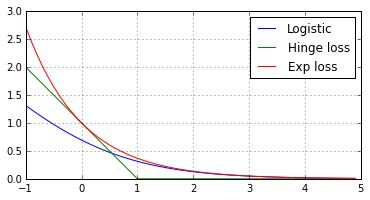

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

def logit_loss(s):
    return np.log(1 + np.exp(-s))

def hinge_loss(s):
    return np.maximum(0, 1-s)

def exp_loss(s):
    return np.exp(-s)

s = np.arange(-1, 5, 0.1)

# plot the sigmoid curve.
plt.figure(figsize=(6, 3))
plt.plot(s, logit_loss(s), label="Logistic")
plt.plot(s, hinge_loss(s), label="Hinge loss")
plt.plot(s, exp_loss(s), label="Exp loss")
plt.grid()
plt.legend()
plt.show()

## Training

Examine the loss function
$$\ell_{AdaBoost} = \sum_{i=1}^{n} e^{-y_i \sum_{k=1}^{m}\beta_k h_k(x_i)}.$$

Intuitively, the set of $h_k()$'s forms a committe, each member has a voting weight $\beta_k$. The classification decision is made based on the voting of committe members, $\textrm{sign}\left(\sum_k \beta_k h_k(x_i)\right)$.

When training a AdaBoost classifier, we usually use a sequential method where we select committe memebers one after another so that training examples are getting separated gradually.

Suppose a commitee with $k$ classifiers, we want to add a new memeber $h_\textrm{new}$. The votes are
$$
\begin{align}
\textrm{current committe:} \quad & \sum_{i=1}^{m} \beta_k h_k(x_i), \\
\textrm{add a new member:} \quad & \sum_{i=1}^{m} \beta_k h_k(x_i) + \beta_\textrm{new} h_\textrm{new}(x_i).
\end{align}
$$

After adding a member, the loss function becomes:
$$\ell_{AdaBoost} = \sum_{i=1}^{n} e^{-y_i \left( \sum_{k=1}^{m}\beta_k h_k(x_i) + \beta_\textrm{new} h_\textrm{new}(x_i) \right)},$$

Take derivative
$$\dfrac{\partial \ell}{\partial \beta_\textrm{new}} = \sum_{i=1}^{n} e^{-y_i \left( \sum_{k=1}^{m}\beta_k h_k(x_i)+ \beta_\textrm{new} h_\textrm{new}(x_i) \right)}\cdot \left(- y_i h_\textrm{new}(x_i)\right).$$


### Choose a new member $h_\textrm{new}$

At the point we haven't choose a new member, $\beta_\textrm{new} =0$, the above gradient can be written as

$$\dfrac{\partial \ell}{\partial \beta_\textrm{new}}\Bigr|_{\substack{\beta_{\textrm{new}}=0}} = \sum_{i=1}^{n} e^{-y_i \left( \sum_{k=1}^{m}\beta_k h_k(x_i)\right)}\cdot \left(- y_i h_\textrm{new}(x_i)\right) = -\sum_{i=1}^{n} w_i y_i h_\textrm{new}(x_i),$$
where $$w_i = e^{-y_i \left( \sum_{k=1}^{m}\beta_k h_k(x_i)\right)}.$$

Here we want to choose the weak classifer $h_\textrm{new}$ which gives the maximum drop in loss, i.e. we want to maximize $\sum_{i=1}^{n} w_i y_i h_\textrm{new}(x_i)$.

Intuitively, we can consider the original training examples being _weighted_ by $w_i$'s (voting from current committe). The correctly classified examples receive lower weights, whereas the wrongly classified examples get higher weights. Then the ideal $h_\textrm{new}$ is the one which can do well in this weighted examples among all candidates. This new weak classifier therefore comes to resolve the issues that the current committe cannot handle well.

### Determine the voting weight $\beta_\textrm{new}$

To find $\beta_\textrm{new}$, we set the derivative to 0,
$$
\begin{align}
\dfrac{\partial \ell}{\partial \beta_\textrm{new}} &= 0, \\
\sum_{i=1}^{n} w_i e^{-y_i \beta_\textrm{new} h_\textrm{new}(x_i)}\cdot y_i h_\textrm{new}(x_i) &= 0,\\
\sum_{i\in \textrm{correct}} w_i e^{-\beta_\textrm{new}} &= \sum_{i\in \textrm{wrong}} w_i e^{\beta_\textrm{new}},\\
\sum_{i\in \textrm{correct}} w_i &= \sum_{i\in \textrm{wrong}} w_i e^{2\beta_\textrm{new}}.
\end{align}
$$
If we define _error rate_ as $\epsilon = \dfrac{\sum_{i\in \textrm{wrong}}w_i}{\sum_{i}w_i}$, $\beta_\textrm{new}$ can be written as 
$$
\beta_{\textrm{new}} = \dfrac{1}{2} \log\dfrac{1- \epsilon}{\epsilon}.
$$

It says that the weight is determined by how much error $h_\textrm{new}$ made on the weighted data.
This also explains the name of AdaBoost, where "Ada" means _adapative_.

In [2]:
np.random.seed(1)

def adaboost(X, y, X_test, y_test, num_iteration=50):
    n, p = X.shape
    
    th = 0.8
    X_transformed = 2*(X > th) - 1
    X_test_transformed = 2*(X_test > th) - 1
    
    acc, acc_test = [], []
    
    beta = np.zeros((p, 1))
    
    # Initially, all weights are same.
    weights = np.ones((n, 1))
    
    # Results from weak classifier: yi * h(x_i)
    weak_results = y*X_transformed > 0
    
    for i in xrange(num_iteration):
        # Normalize weights.
        weights = weights / np.sum(weights)
        
        # Calculate the error on weighted examples.
        weighted_weak_results = weights * weak_results
        weighted_accuracy = np.sum(weighted_weak_results, axis=0)
        error = 1 - weighted_accuracy

        # Select the one with the min error and update the beta.
        j = np.argmin(error)
        dbeta = np.log((1 - error[j])/error[j])/2
        beta[j] = beta[j] + dbeta
        
        # Update the weights sequentially to avoid overflow.
        weights = weights * np.exp(-dbeta*weak_results[:,j].reshape((n, 1)))
        
        # Calcualte accuracy on training and testing data.
        score = X_transformed.dot(beta)
        acc.append(np.mean(np.sign(score) == y))
        acc_test.append(np.mean(np.sign(X_test_transformed.dot(beta)) == y_test))
    
    return beta, acc, acc_test

# training: 255
# testing : 110


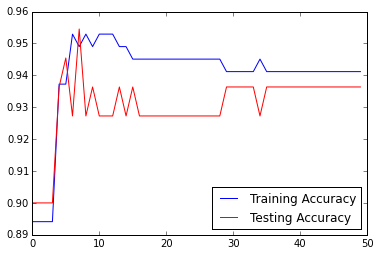

In [3]:
from common import load_digits, split_samples

# Load digits and split the data into two sets.
digits, labels = load_digits(subset=[3, 5], normalize=True)
training_digits, training_labels, testing_digits, testing_labels = split_samples(digits, labels)

print '# training:', training_digits.shape[0]
print '# testing :', testing_digits.shape[0]

# Transform labels from {0, 1} to {-1, 1}.
training_labels = 2* training_labels -1
testing_labels = 2* testing_labels -1

# Train a svm classifier.
beta, acc, acc_test = adaboost(training_digits, training_labels, testing_digits, testing_labels)

# Plot the accuracy.
plt.figure()
plt.plot(range(len(acc)), acc, color='b', label='Training Accuracy')
plt.plot(range(len(acc)), acc_test, color='r', label='Testing Accuracy')
plt.legend(loc='best')
plt.show()

## Remarks and a bit of history

AdaBoost was originally developed for answering a theoretical question about "whether strong learning = weak learning" (starting from the perspective of game theory instead of loss function). Then it turns out to be very useful in practice. AdaBoost seldom overfits. Most of the time, the loss function tries to increase the margin. One can be saved from overfitting only by training the classifier sequentially. The key lies in the fixing weights for the already learned classifiers. If, otherwise, you minimize the loss function using gradient descent, the resulting classifier will overfit.

The original idea of boosting was non-adapative.
* Read in a batch of (say 100) examples, learn a $h_1$;
* Read another 100 examples, classify using $h_1$, then learn a new classifier $h_2$ with the mistake;
* Read another 100 examples, classify using $h_1, h_2$, then learn $h_3$ with the mistake.

The committe simply perform a majority vote by $h_1+h_2+h3$. One can use this method to get a lot of committes and futher form bigger committes. Still, this gives you $\sum_k h_k$.

Later people discovered this adapative boosting, which gives a voting weight $\beta_k$ to each classifier $h_k$.